<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [8]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [61]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

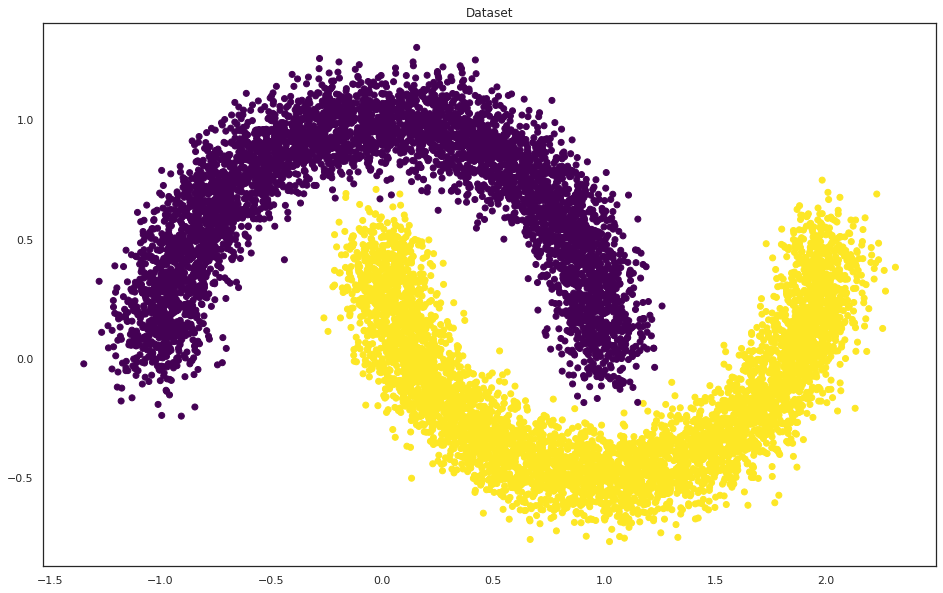

In [62]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [64]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [65]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, drop_last=True)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [78]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn([in_features,out_features]))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn([out_features])) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [77]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

**Ответ** У данной модели 2 обучаемых параметра (в матрцие W) и 1 параметр в свободном члене (всего 3 шт)

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [16]:
def binary_cross_entropy(predicted, true):
    return -(true * predicted.log() + (1 - true) * (1 - predicted).log()).mean()
def logistic(z):
    return 1 / (1 + torch.exp(-z))

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs

        loss =  loss_function(outp.view(-1), y_batch.view(-1)) # YOUR CODE. Compute loss
        
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = logistic(outp) # YOUR CODE
        
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.1484375
Iteration: 100
Batch accuracy: 0.34375
Iteration: 200
Batch accuracy: 0.6953125
Iteration: 300
Batch accuracy: 0.75
Iteration: 400
Batch accuracy: 0.8046875
Iteration: 500
Batch accuracy: 0.7421875
Iteration: 600
Batch accuracy: 0.8515625
Iteration: 700
Batch accuracy: 0.84375
Iteration: 800
Batch accuracy: 0.8671875
Iteration: 900
Batch accuracy: 0.8203125
Iteration: 1000
Batch accuracy: 0.8515625

Iteration: 1033.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** Потребовалось 1033 итераций

### Визуализируем результаты

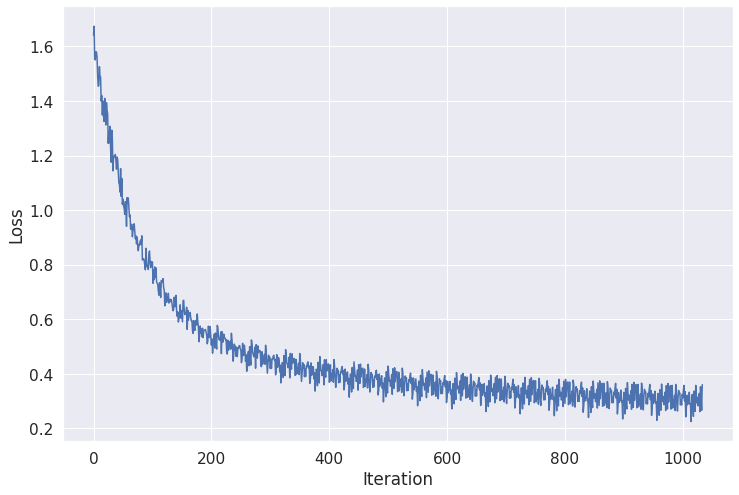

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

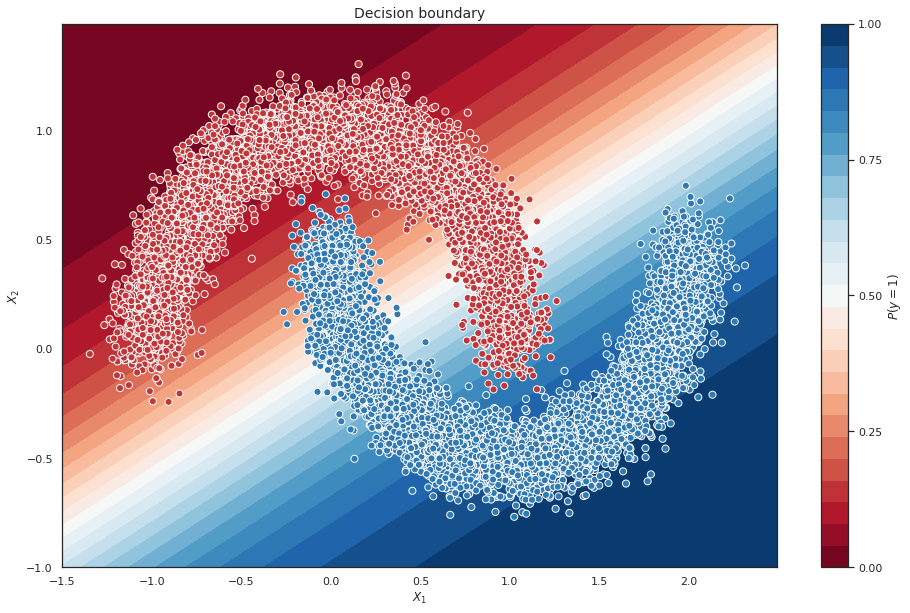

In [18]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [19]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, y_batch in dataloader:
        outp = model.forward(X_batch)
        probabilities = logistic(outp) # YOUR CODE
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [20]:
from sklearn.metrics import accuracy_score
pred = predict(val_dataloader, linear_regression)
# YOUR CODE. Compute total accuracy
accuracy_score(y_val[0:-68], pred)

0.5020559210526315

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** Я получил на обучении accuracy=89%, а на тесте accuracy=50%

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [21]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128, drop_last=True) # YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [22]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [24]:
from torchsummary import summary

activation = nn.ELU
features = 28*28;

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
)

# summary(model, (1,28, 28))

In [25]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [27]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval() 
              with torch.no_grad():
                outp = model(x_batch)  
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds==y_batch).sum() # YOUR CODE GOES HERE
            all =  128 # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step() 
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8801081730769231
Loader: valid. Accuracy: 0.9311899038461539
Epoch: 2
Loader: train. Accuracy: 0.9427250267094017
Loader: valid. Accuracy: 0.9559294871794872
Epoch: 3
Loader: train. Accuracy: 0.9604366987179487
Loader: valid. Accuracy: 0.9629407051282052
Epoch: 4
Loader: train. Accuracy: 0.9693342681623932
Loader: valid. Accuracy: 0.9647435897435898
Epoch: 5
Loader: train. Accuracy: 0.9748931623931624
Loader: valid. Accuracy: 0.9643429487179487
Epoch: 6
Loader: train. Accuracy: 0.9790998931623932
Loader: valid. Accuracy: 0.9649439102564102
Epoch: 7
Loader: train. Accuracy: 0.9821047008547008
Loader: valid. Accuracy: 0.9706530448717948
Epoch: 8
Loader: train. Accuracy: 0.9841579861111112
Loader: valid. Accuracy: 0.9645432692307693
Epoch: 9
Loader: train. Accuracy: 0.9854266826923077
Loader: valid. Accuracy: 0.9583333333333334
Epoch: 10
Loader: train. Accuracy: 0.9857772435897436
Loader: valid. Accuracy: 0.9633413461538461


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [29]:
elu_accuracy = accuracy["valid"]

In [30]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  #YOUR CODE
  # activation = nn.ELU
  features = 28*28;

  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, 10)
      #YOUR CODE. Add layers to your sequential class
  )

  criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
  optimizer = torch.optim.Adam(model.parameters())
  loaders = {"train": train_dataloader, "valid": valid_dataloader}

  max_epochs = 10
  accuracy = {"train": [], "valid": []}

  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
              else:
                model.eval() 
                with torch.no_grad():
                  outp = model(x_batch)  
                  # YOUR CODE. Set model to ``eval`` mode and calculate outputs
              preds = outp.argmax(-1)
              correct = (preds==y_batch).sum() # YOUR CODE GOES HERE
              all =  128 # YOUR CODE GOES HERE
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step() 
                  # YOUR CODE. Calculate gradients and make a step of your optimizer
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy["valid"]

In [31]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)#YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)#YOUR CODE

Epoch: 1
Loader: train. Accuracy: 0.8650507478632479
Loader: valid. Accuracy: 0.8860176282051282
Epoch: 2
Loader: train. Accuracy: 0.8966513087606838
Loader: valid. Accuracy: 0.8972355769230769
Epoch: 3
Loader: train. Accuracy: 0.900657719017094
Loader: valid. Accuracy: 0.8974358974358975
Epoch: 4
Loader: train. Accuracy: 0.902877938034188
Loader: valid. Accuracy: 0.9011418269230769
Epoch: 5
Loader: train. Accuracy: 0.9043636485042735
Loader: valid. Accuracy: 0.9009415064102564
Epoch: 6
Loader: train. Accuracy: 0.9056156517094017
Loader: valid. Accuracy: 0.9009415064102564
Epoch: 7
Loader: train. Accuracy: 0.9069678151709402
Loader: valid. Accuracy: 0.9018429487179487
Epoch: 8
Loader: train. Accuracy: 0.9082532051282052
Loader: valid. Accuracy: 0.9017427884615384
Epoch: 9
Loader: train. Accuracy: 0.9091045673076923
Loader: valid. Accuracy: 0.9027443910256411
Epoch: 10
Loader: train. Accuracy: 0.9100894764957265
Loader: valid. Accuracy: 0.9043469551282052
Epoch: 1
Loader: train. Accurac

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

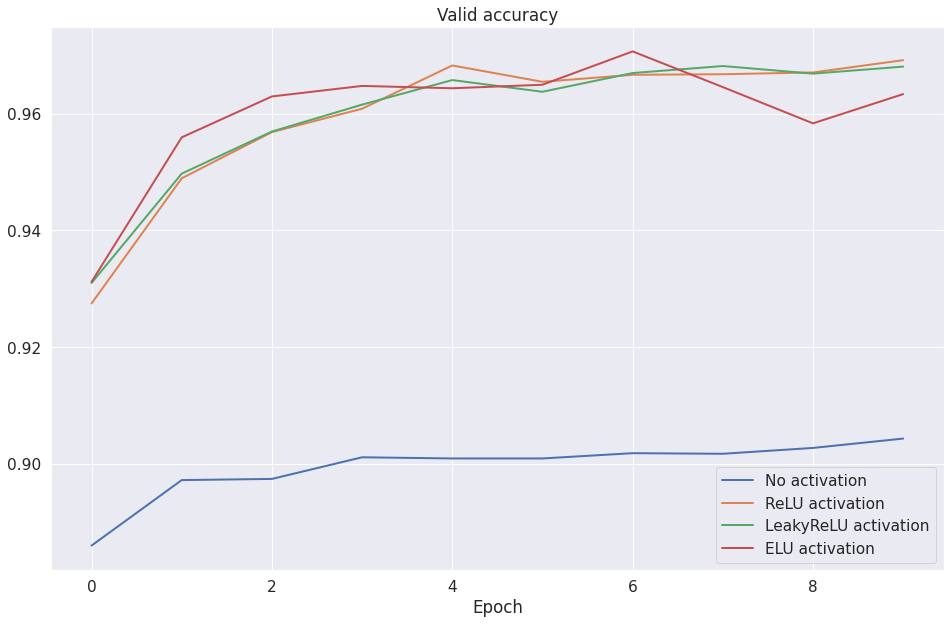

In [32]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

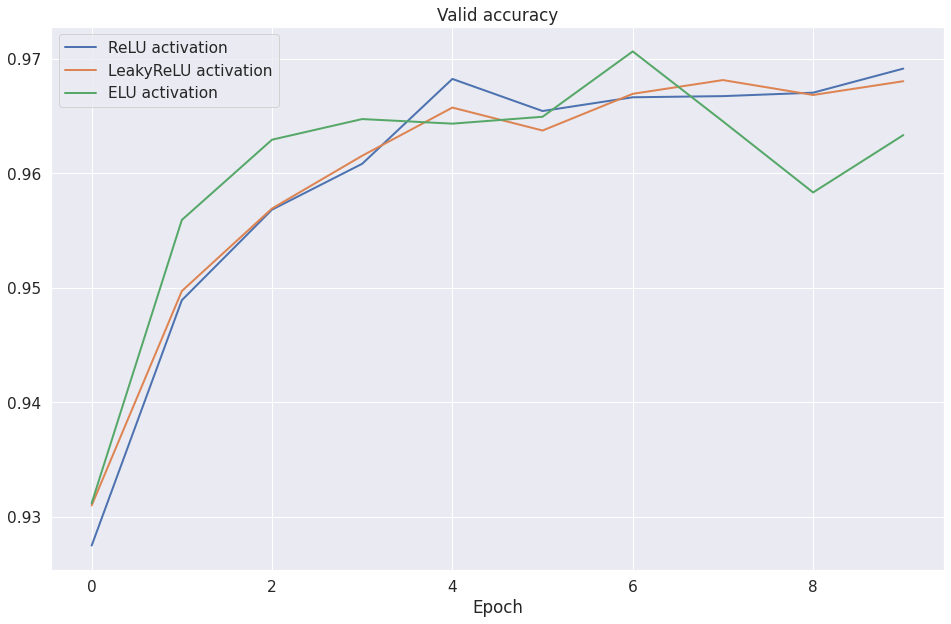

In [33]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU активаций показала наивысший `accuracy`

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [34]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-27 16:28:59--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-27 16:29:00--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  91.8KB/s    in 0.5s    

2021-11-27 16:29:02 (91.8 KB/s) - ‘sample_photo.jpg’ saved [49337/

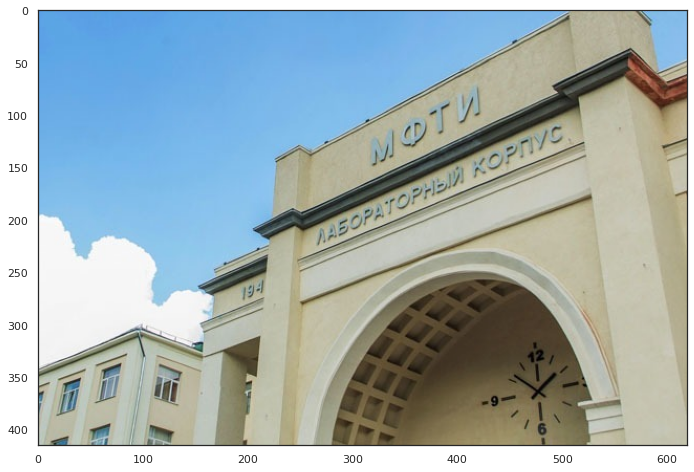

In [35]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [36]:
a = [[0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]]

b = [[0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]]

c = [[0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]]

d = [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]]

e = [[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]]
    
f = [[0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]]

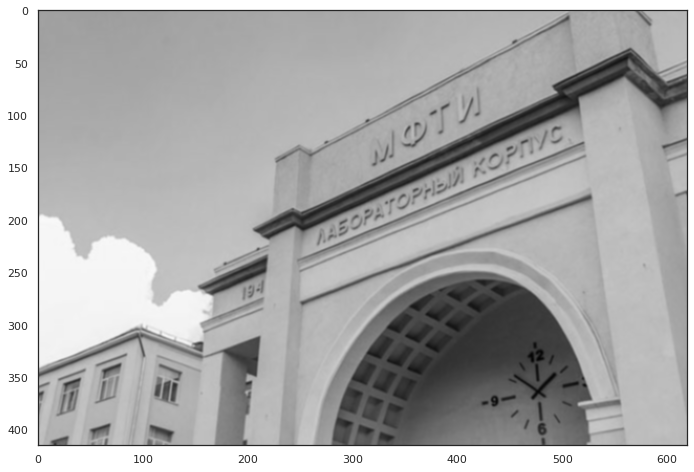

In [37]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor(f).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3
plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1. - e, 
2. - а, 
3. - д, 
4. - в, 
5. - б, 
6. - г, 

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [38]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1) #YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1) #YOUR CODE
        self.fc1 = nn.Linear(16 * 22 * 22, 120) #YOUR CODE  
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        x = F.relu(self.conv1(x)) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 22 * 22)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [46]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [48]:
from tqdm import tqdm_notebook

max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in tqdm_notebook(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm_notebook(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)
              # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval() 
              with torch.no_grad():
                outp = model(x_batch)  
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds==y_batch).sum() # YOUR CODE GOES HERE
            all =  128 # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step() 
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9238615117521367


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9752604166666666


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9793002136752137


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9845753205128205


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9867120726495726


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9845753205128205


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9899505876068376


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9853766025641025


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9922375801282052


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9862780448717948


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9937733707264957


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9881810897435898


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9947749732905983


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9860777243589743


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9944577991452992


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9858774038461539


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9966446314102564


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.98828125


  0%|          | 0/468 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9965778579059829


  0%|          | 0/78 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9853766025641025


In [49]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

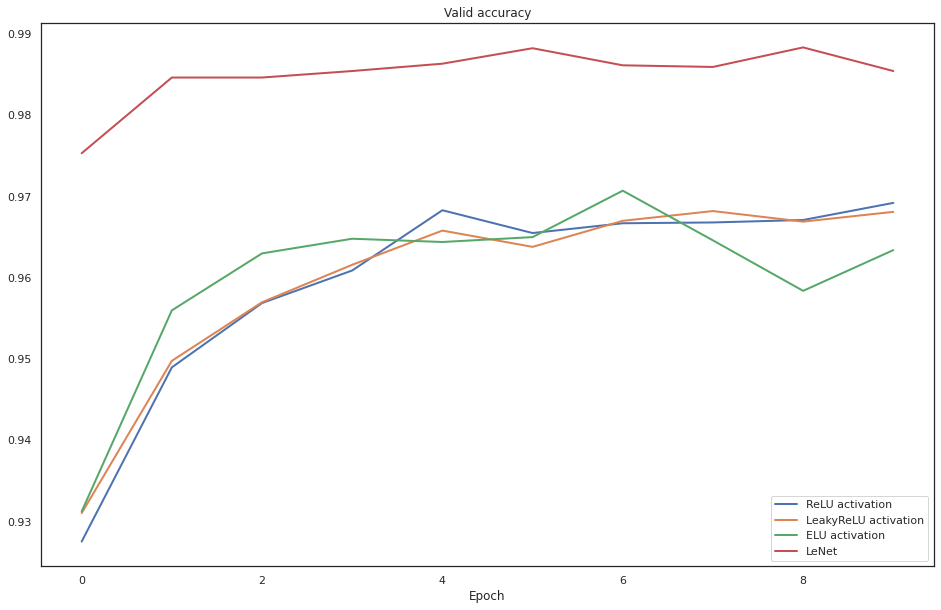

In [51]:
max_epochs = 10

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** accuracy = 0.99